## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
from tensorflow.keras import activations
from keras.regularizers import l1_l2
from keras.layers import Dropout

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=0.0, l2_ratio=0.0, drp_ratio=0.1):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    x = BatchNormalization()(input_layer)

    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
            x = BatchNormalization()(x)            
            x = keras.layers.Activation(activations.relu)(x)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
            x = BatchNormalization()(x)
            x = keras.layers.Activation(activations.relu)(x)
            x = Dropout(drp_ratio)(x)            

    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 10
BATCH_SIZE = 256
MOMENTUM = 0.95
Dropout_EXP = 0.2
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for l1r, l2r in itertools.product(L1_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with L1 = %.6f, L2 = %.6f" % (l1r, l2r))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1r, l2_ratio=l2r)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l1-%s-l2-%s" % (str(l1r), str(l2r))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with L1 = 0.010000, L2 = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normaliz

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 26s 513us/step - loss: 198.5861 - accuracy: 0.3204 - val_loss: 42.3251 - val_accuracy: 0.1093
Epoch 2/10
50000/50000 [==============================] - 23s 456us/step - loss: 21.2917 - accuracy: 0.3278 - val_loss: 10.2489 - val_accuracy: 0.1000
Epoch 3/10
50000/50000 [==============================] - 23s 457us/step - loss: 5.4673 - accuracy: 0.3380 - val_loss: 3.7890 - val_accuracy: 0.1050
Epoch 4/10
50000/50000 [==============================] - 23s 454us/step - loss: 2.8435 - accuracy: 0.3492 - val_loss: 3.0647 - val_accuracy: 0.1802
Epoch 5/10
50000/50000 [==============================] - 23s 470us/step - loss: 2.6853 - accuracy: 0.3472 - val_loss: 3.1058 - val_accuracy: 0.1962
Epoch 6/10
50000/50000 [==============================] - 23s 468us/step - loss: 2.6566 - accuracy: 0.3436 - val_loss: 3.3957 - val_accuracy: 0.1464
Epoch 7/10
50000/50000 [===========================

50000/50000 [==============================] - 21s 421us/step - loss: 2.8225 - accuracy: 0.3473 - val_loss: 3.1477 - val_accuracy: 0.1753
Epoch 5/10
50000/50000 [==============================] - 21s 418us/step - loss: 2.6657 - accuracy: 0.3429 - val_loss: 2.9611 - val_accuracy: 0.2127
Epoch 6/10
50000/50000 [==============================] - 21s 420us/step - loss: 2.6530 - accuracy: 0.3414 - val_loss: 3.6857 - val_accuracy: 0.1653
Epoch 7/10
50000/50000 [==============================] - 21s 416us/step - loss: 2.6521 - accuracy: 0.3443 - val_loss: 3.2641 - val_accuracy: 0.1892
Epoch 8/10
50000/50000 [==============================] - 21s 424us/step - loss: 2.6450 - accuracy: 0.3443 - val_loss: 3.4346 - val_accuracy: 0.2150
Epoch 9/10
50000/50000 [==============================] - 22s 432us/step - loss: 2.6351 - accuracy: 0.3443 - val_loss: 2.9886 - val_accuracy: 0.2275
Epoch 10/10
50000/50000 [==============================] - 21s 420us/step - loss: 2.6129 - accuracy: 0.3394 - val_los

50000/50000 [==============================] - 23s 460us/step - loss: 4.9501 - accuracy: 0.5253 - val_loss: 5.0020 - val_accuracy: 0.4930
Epoch 9/10
50000/50000 [==============================] - 23s 462us/step - loss: 4.8510 - accuracy: 0.5388 - val_loss: 4.8987 - val_accuracy: 0.5050
Epoch 10/10
50000/50000 [==============================] - 23s 462us/step - loss: 4.7579 - accuracy: 0.5453 - val_loss: 4.8754 - val_accuracy: 0.4907
Experiment with L1 = 0.000100, L2 = 0.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_______________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 23s 465us/step - loss: 5.9406 - accuracy: 0.3056 - val_loss: 5.7345 - val_accuracy: 0.3808
Epoch 2/10
50000/50000 [==============================] - 21s 419us/step - loss: 5.5791 - accuracy: 0.4069 - val_loss: 5.4707 - val_accuracy: 0.4356
Epoch 3/10
50000/50000 [==============================] - 21s 423us/step - loss: 5.4143 - accuracy: 0.4429 - val_loss: 5.3436 - val_accuracy: 0.4542
Epoch 4/10
50000/50000 [==============================] - 22s 442us/step - loss: 5.2853 - accuracy: 0.4668 - val_loss: 5.2447 - val_accuracy: 0.4709
Epoch 5/10
50000/50000 [==============================] - 21s 424us/step - loss: 5.1680 - accuracy: 0.4855 - val_loss: 5.1456 - val_accuracy: 0.4821
Epoch 6/10
50000/50000 [==============================] - 21s 426us/step - loss: 5.0606 - accuracy: 0.4985 - val_loss: 5.0690 - val_accuracy: 0.4817
Epoch 7/10
50000/50000 [==============================] 

50000/50000 [==============================] - 23s 459us/step - loss: 1.6536 - accuracy: 0.4628 - val_loss: 1.6590 - val_accuracy: 0.4618
Epoch 5/10
50000/50000 [==============================] - 23s 469us/step - loss: 1.6022 - accuracy: 0.4790 - val_loss: 1.6261 - val_accuracy: 0.4684
Epoch 6/10
50000/50000 [==============================] - 23s 464us/step - loss: 1.5576 - accuracy: 0.4948 - val_loss: 1.5926 - val_accuracy: 0.4786
Epoch 7/10
50000/50000 [==============================] - 24s 476us/step - loss: 1.5188 - accuracy: 0.5103 - val_loss: 1.5884 - val_accuracy: 0.4817
Epoch 8/10
50000/50000 [==============================] - 24s 480us/step - loss: 1.4880 - accuracy: 0.5190 - val_loss: 1.5601 - val_accuracy: 0.4965
Epoch 9/10
50000/50000 [==============================] - 24s 477us/step - loss: 1.4548 - accuracy: 0.5320 - val_loss: 1.5652 - val_accuracy: 0.4882
Epoch 10/10
50000/50000 [==============================] - 24s 476us/step - loss: 1.4247 - accuracy: 0.5433 - val_los

50000/50000 [==============================] - 23s 467us/step - loss: 1.3508 - accuracy: 0.5220 - val_loss: 1.4396 - val_accuracy: 0.4913
Epoch 9/10
50000/50000 [==============================] - 23s 459us/step - loss: 1.3252 - accuracy: 0.5298 - val_loss: 1.4056 - val_accuracy: 0.4992
Epoch 10/10
50000/50000 [==============================] - 23s 467us/step - loss: 1.2966 - accuracy: 0.5400 - val_loss: 1.4044 - val_accuracy: 0.4985
Experiment with L1 = 0.000000, L2 = 0.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_______________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 25s 503us/step - loss: 2.1070 - accuracy: 0.3092 - val_loss: 1.9225 - val_accuracy: 0.3720
Epoch 2/10
50000/50000 [==============================] - 23s 462us/step - loss: 1.8139 - accuracy: 0.4077 - val_loss: 1.7522 - val_accuracy: 0.4331
Epoch 3/10
50000/50000 [==============================] - 23s 463us/step - loss: 1.7193 - accuracy: 0.4398 - val_loss: 1.6859 - val_accuracy: 0.4538
Epoch 4/10
50000/50000 [==============================] - 23s 461us/step - loss: 1.6528 - accuracy: 0.4641 - val_loss: 1.6676 - val_accuracy: 0.4573
Epoch 5/10
50000/50000 [==============================] - 23s 458us/step - loss: 1.5988 - accuracy: 0.4836 - val_loss: 1.5943 - val_accuracy: 0.4863
Epoch 6/10
50000/50000 [==============================] - 23s 463us/step - loss: 1.5556 - accuracy: 0.4994 - val_loss: 1.5745 - val_accuracy: 0.4926
Epoch 7/10
50000/50000 [==============================] 

Epoch 5/10
50000/50000 [==============================] - 23s 462us/step - loss: 1.4640 - accuracy: 0.4806 - val_loss: 1.4725 - val_accuracy: 0.4777
Epoch 6/10
50000/50000 [==============================] - 23s 457us/step - loss: 1.4195 - accuracy: 0.4960 - val_loss: 1.4339 - val_accuracy: 0.4947
Epoch 7/10
50000/50000 [==============================] - 23s 460us/step - loss: 1.3801 - accuracy: 0.5136 - val_loss: 1.4516 - val_accuracy: 0.4891
Epoch 8/10
50000/50000 [==============================] - 23s 463us/step - loss: 1.3484 - accuracy: 0.5212 - val_loss: 1.4405 - val_accuracy: 0.4901
Epoch 9/10
50000/50000 [==============================] - 23s 463us/step - loss: 1.3165 - accuracy: 0.5332 - val_loss: 1.4276 - val_accuracy: 0.4928
Epoch 10/10
50000/50000 [==============================] - 23s 462us/step - loss: 1.2879 - accuracy: 0.5437 - val_loss: 1.3843 - val_accuracy: 0.5120
Experiment with L1 = 0.000000, L2 = 0.000000
Model: "model_1"
___________________________________________

50000/50000 [==============================] - 21s 417us/step - loss: 4.9836 - accuracy: 0.5609 - val_loss: 5.0390 - val_accuracy: 0.4180
Epoch 10/10
50000/50000 [==============================] - 21s 421us/step - loss: 4.4219 - accuracy: 0.5699 - val_loss: 4.5256 - val_accuracy: 0.4436
Experiment with L1 = 0.000000, L2 = 0.000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
________________________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 23s 470us/step - loss: 1.9600 - accuracy: 0.3083 - val_loss: 1.7547 - val_accuracy: 0.3894
Epoch 2/10
50000/50000 [==============================] - 22s 433us/step - loss: 1.6699 - accuracy: 0.4077 - val_loss: 1.5942 - val_accuracy: 0.4435
Epoch 3/10
50000/50000 [==============================] - 18s 367us/step - loss: 1.5701 - accuracy: 0.4434 - val_loss: 1.5350 - val_accuracy: 0.4512
Epoch 4/10
50000/50000 [==============================] - 20s 401us/step - loss: 1.5080 - accuracy: 0.4637 - val_loss: 1.4890 - val_accuracy: 0.4682
Epoch 5/10
50000/50000 [==============================] - 23s 453us/step - loss: 1.4592 - accuracy: 0.4827 - val_loss: 1.4939 - val_accuracy: 0.4705
Epoch 6/10
50000/50000 [==============================] - 22s 434us/step - loss: 1.4097 - accuracy: 0.4988 - val_loss: 1.4492 - val_accuracy: 0.4874
Epoch 7/10
50000/50000 [==============================] 

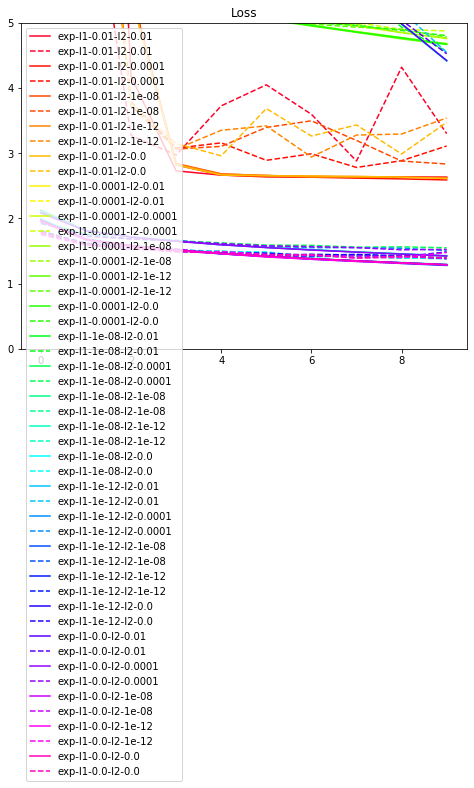

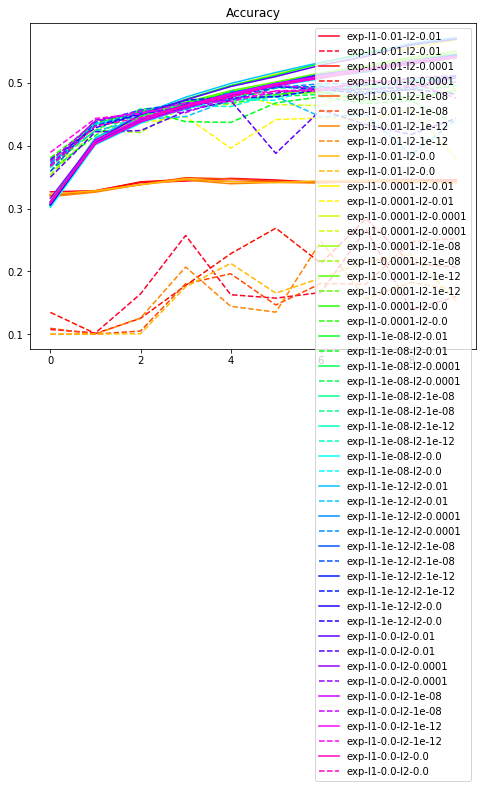

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
import matplotlib.cm as mplcm
import matplotlib.colors as colors
NUM_COLORS = 25

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()